# Capstone Project

#### Goals

1. Provide a description of the problem, and a discussion of the background
2. Provide a description of the data and how it will be used to solve the problem

## Introduction / Business Problem

**Problem Description**: Many young families in Australia are struggling to find affordable housing. Inspired by this issue, I was drawn to collect past sales data from real estate websites, and combine this with FourSquare location data to build a simple predictive model that estimates a fair market value for a given property currently on the market, based upon its similarity to past sales and its location (+ external factors such as time of sale). This model is likely to be limited by data availability, as many major real estate websites in Australia expressly forbid automated web scraping. For now, we focus on a region of particular personal interest: Canberra and the surrounds.

**Data Description**:
1. **Real Estate Data**: The following pieces of data have been scraped from https://www.auhouseprices.com/act/, which to the best of my knowledge, does not forbid web scraping.
    (a) Recent sales
    (b) Suburb Names
    (c) Sold Prices
    (d) Sold Date
    (e) Property Type
    (f) Number of beds, baths, and car spaces
    (g) Location (latitude and longitude)

2. **Suburb Data**: The latitude and longitude of each suburb name, (itself extracted from the above data source), was obtained using the OpenCage API.

3. **Venue Data**: Per previous work, location data can be served for free (with limitations) via the FourSquare API. We will use this to collect information about venues near previously-sold and for-sale houses. 

4. **Mapping Data:** Maps are generated interactively using Folium, with suburb boundary data obtained from data.gov.au: https://data.gov.au/dataset/ds-dga-0257a9da-b558-4d86-a987-535c775cf8d8/details?q=act%20suburb

## Data

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import math
import numpy as np

In [2]:
url = "https://www.auhouseprices.com/act/"
req = requests.get(url)
soup = BeautifulSoup(req.text, 'lxml')

outlist = []
for tag in soup.find_all("li", {"class": "list-group-item"})[:48]:
    for link in tag('a'):
        href = link.get('href')

    postcode = tag.text.split()[1]
    name = tag.text.split('-')[-1]
    houses_sold = tag.text.split()[0]
    outlink = href

    outlist.append([postcode, name, houses_sold, outlink])

columns = ['Postcode', 'Name', 'Recent Sales', 'Suburb Link']
df = pd.DataFrame(outlist, columns=columns)

df.head()

Postcode          Name Recent Sales  \
0     2620   Queanbeyan           226   
1     2902       Kambah           221   
2     2913    Ngunnawal           131   
3     2913        Casey           116   
4     2615    Macgregor           107   

                                         Suburb Link  
0  https://www.auhouseprices.com/sold/list/ACT/26...  
1  https://www.auhouseprices.com/sold/list/ACT/29...  
2  https://www.auhouseprices.com/sold/list/ACT/29...  
3  https://www.auhouseprices.com/sold/list/ACT/29...  
4  https://www.auhouseprices.com/sold/list/ACT/26...

### Collecting House Sale Data by Suburb

Using the above dataframe to determine which of all possible suburbs we can easily collect data for, we create a dataset for each suburb. Technically, we could do this all in one iteration for all available suburbs, but the scraping was (justifiably) rate-limited, so I do it one suburb at a time. We will link all the data back together at the end

Note that we can determine the number of child webpages from ceiling(${total_sales}/12)

In [540]:
## Some of the initial info for each row comes from the parent dataframe
columns = ["Postcode", "Suburb Name", "Recent Sales", "Suburb Link", "Street Address", "Latitude", "Longitude", "Property Type", "Beds", "Baths", "Cars", "Sold Price", "Sold Date", "Property Link"]

for i in range(0, len(df)):
    data = []
    postcode = df.iloc[i]["Postcode"]
    sub_name = df.iloc[i]["Name"].lstrip().rstrip()
    recent_sales = df.iloc[i]["Recent Sales"]
    sub_link = df.iloc[i]["Suburb Link"]
    
    ## use data on first page to determine total number of pages
    first_url = f"{sub_link}1"
    req = requests.get(first_url)
    soup = BeautifulSoup(req.text, 'lxml')

    ## get the total number of houses for which data exists in the suburb
    for tag in soup.find("div", {"class": "headline"}):
        total_suburb_houses_sold = tag.text.split()[-1]
    
    ## use that number to calculate the number of pages to iterate through, assuming 12 results per page
    npages = math.ceil(int(total_suburb_houses_sold)/12)
    
    for page in range(npages):
        
        url = f"{sub_link}{page+1}"
        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'lxml')
        
        for tag in soup.find_all("div", {"class": "col-md-4 col-sm-6 md-margin-bottom-20"}):

            ## There must be at least 4 attributes and the last one must be a price.
            ## If the house does not have complete data, then we don't want it in our model.
            ## Do this check first before we collect the rest of the data
            nbed, nbath, ncar = np.nan, np.nan, np.nan
            attrs = tag.find_all("li")[1].text.split()
            if len(attrs)==4 and "$" in attrs[-1]:
                nbed, nbath, ncar = attrs[0:3]

                #print(tag.find("ul", {"class": "list-unstyled"})) ## contains the contents of the cell of interest
                sold_date = tag.find("ul", {"class": "list-unstyled"}).find("li").text.strip("Sold on ")
                property_link = tag.find("a").get('href')
                sold_price = tag.find("span", {"class": "pull-right"}).text
                if "$" not in sold_price:
                    sold_price = np.nan
    
                property_map = tag.find("a", {"class": "btn-u btn-u-xs btn-view-map init"})
                latitude = property_map['data-lat']
                longitude = property_map['data-lng']    
    
                ## remove the 'small' tag, this adds redundant suburb name and postcode
                tag.small.decompose()
                street_address = tag.find("h4").text
            
                ## probably a more intelligent way to do this
                property_type_list = [
                    tag.find("div", {"class:", "easy-block-v1-badge rgba-blue"}),\
                    tag.find("div", {"class:", "easy-block-v1-badge rgba-red"}),\
                    tag.find("div", {"class:", "easy-block-v1-badge rgba-purple"}),\
                    tag.find("div", {"class:", "easy-block-v1-badge rgba-default"})]
            
                property_type = [_ for _ in property_type_list if _]
                try:
                    property_type = property_type[0].text
                except AttributeError:
                    print(f"Error: Property Type not found for {url}, {street_address}")
                    
                data.append([postcode, sub_name, recent_sales, sub_link, street_address, latitude, longitude, property_type, nbed, nbath, ncar, sold_price, sold_date, property_link])

    new_df = pd.DataFrame(data, columns=columns)
    new_df.to_csv(f"canberra_property_data_{sub_name}.csv")

### Concatenate Suburb Dataframes

In [3]:
columns = ["Index", "Postcode", "Suburb Name", "Recent Sales", "Suburb Link", "Street Address", "Latitude", "Longitude", "Property Type", "Beds", "Baths", "Cars", "Sold Price", "Sold Date", "Property Link"]

all_sales_data_df = pd.DataFrame(columns=columns)

for i in range(0, len(df)):
    sub_name = df.iloc[i]["Name"].lstrip().rstrip()
    current_df = pd.read_csv(f"canberra_property_data_{sub_name}.csv")
    all_sales_data_df = all_sales_data_df.append(current_df, ignore_index=True)

all_sales_data_df.drop(columns=["Index"], inplace=True)
all_sales_data_df.drop(columns=["Unnamed: 0"], inplace=True)
all_sales_data_df.to_csv(f"canberra_property_data_allsuburbs.csv")

### Data Cleaning

In [4]:
houses = all_sales_data_df

## messy, but there we go
houses["Postcode"] = houses["Postcode"].astype('int')
houses["Recent Sales"] = houses["Recent Sales"].astype('int')
houses["Beds"] = houses["Beds"].astype('int')
houses["Baths"] = houses["Baths"].astype('int')
houses["Cars"] = houses["Cars"].astype('int')
houses["Sold Price"] = houses["Sold Price"].str.replace(r'$', '').str.replace(r',', '').astype('int')

# manual fixing of malformed dates
for i in range(1993, 2022):
    houses["Sold Date"].replace(f"ep {i}", f"Sep {i}", inplace=True)
houses["Sold Date"] = houses["Sold Date"].astype('datetime64')

houses.dtypes

Postcode                   int64
Suburb Name               object
Recent Sales               int64
Suburb Link               object
Street Address            object
Latitude                 float64
Longitude                float64
Property Type             object
Beds                       int64
Baths                      int64
Cars                       int64
Sold Price                 int64
Sold Date         datetime64[ns]
Property Link             object
dtype: object

### Exploratory Data Analysis

Some basic questions:

1. How many suburbs have we collected data on?
2. Over what time period do we have sales data for?
3. What is the min/max/mean/median sale price per suburb?
4. What is the min/max/mean/median number of beds/baths/cars?
5. How many sales per suburb?
6. Any weird bits of data in any column? NaNs?
7. Do we have enough data for each suburb to make reasonable statistical inferences?

In [5]:
print(f"We have data on {len(houses.groupby('Suburb Name'))} Suburbs")

We have data on 48 Suburbs


In [6]:
print(f"Earliest sale: {houses['Sold Date'].min()}")
print(f"Latest sale: {houses['Sold Date'].max()}") 

Earliest sale: 1970-01-01 00:00:00
Latest sale: 2021-03-27 00:00:00


In [7]:
houses.groupby('Suburb Name')["Sold Price"].min()

## define metrics of interest with the agg method
houses.groupby('Suburb Name').agg(
    {
        "Sold Price": ["min", "max", "mean", "median"],
        "Beds": ["min", "max", "mean", "median"],
        "Baths": ["min", "max", "mean", "median"],
        "Cars": ["min", "max", "mean", "median"],
})

Sold Price                                    Beds      \
                       min         max          mean   median  min max   
Suburb Name                                                              
Ainslie                850     2150000  8.462666e+05   780000    1   6   
Amaroo               58000     1400000  5.414722e+05   512000    1   6   
Banks                  336     1187500  4.718799e+05   441000    2   7   
Bonner              190000     1310000  5.831477e+05   575000    1   6   
Calwell                420     1119000  5.016043e+05   475000    1   9   
Campbell             80000     2300000  9.270453e+05   879000    1   8   
Casey                  542     1460000  5.888695e+05   560000    1   7   
Charnwood              375     1912500  3.983857e+05   387750    1   6   
Chisholm               355     1130000  4.893149e+05   476000    2   6   
City                257500     1760000  5.638095e+05   512500    1   4   
Conder                 340     1850000  5.134093e+05   496000    2   9   
Crace               250000     1630000  7.043803e+05   710000    1   7   
Curtin              105000     2335000  7.710203e+05   736250    1   7   
Deakin                 730     5750000  1.069666e+06   965000    1   6   
Dunlop               52000     1380000  4.938470e+05   490000    1  10   
Evatt                  609     1500000  5.120452e+05   490000    1   6   
Farrer               72000     1995000  7.204300e+05   710000    1   7   
Fisher               56500     1200000  5.643231e+05   569500    1   6   
Florey                 645      960000  5.041920e+05   480000    2   7   
Flynn               132000     1250000  5.431112e+05   540000    2   6   
Forde               137000     2035000  6.583634e+05   652000    1   9   
Franklin            175000     1400000  5.475597e+05   522000    1   9   
Giralang            136000     1130000  5.376902e+05   520000    1   7   
Gordon                 320     1088000  4.780674e+05   450000    2   7   
Gowrie              132000      908000  5.555581e+05   541000    2   6   
Gungahlin            85000     5425000  4.940223e+05   470000    1   7   
Harrison            110000    16666666  5.852888e+05   552500    1   6   
Higgins                459      980000  4.701561e+05   454500    1   7   
Holt                 31000      895000  4.114271e+05   397500    1   5   
Hughes                 535     2500000  7.942027e+05   775000    1   6   
Isaacs              220000     2350000  7.407912e+05   720000    1   7   
Isabella Plains        340      845000  4.495997e+05   439400    1   7   
Kaleen                 550     1208000  5.834090e+05   570000    1   8   
Kambah                 325     5250000  5.325776e+05   490000    1   8   
Latham              279500      950000  5.113301e+05   487000    1   7   
Macgregor              360     1286000  4.704135e+05   455000    2   7   
Melba                99000     1475000  5.337611e+05   505250    2   7   
Monash                 405      995000  5.182495e+05   495000    2   7   
Narrabundah            485     4620000  6.965399e+05   635000    1   9   
Ngunnawal              355     1402500  4.546307e+05   425000    1  21   
Nicholls                 1     2475000  6.799734e+05   640000    2   7   
O'Connor            200000     2615000  8.431971e+05   805000    1   8   
Queanbeyan             420     3000000  4.679615e+05   436000    1  27   
Rivett                 421  1536746354  3.977016e+06   520000    2   7   
Wanniassa              320     1350000  5.193315e+05   510000    1   6   
Watson               57000     1570000  5.282385e+05   500000    1   7   
Weston                 440     2525000  6.003636e+05   565000    1   6   
Yarralumla            1000     5475000  1.133971e+06  1000000    1   7   

                                 Baths                      Cars       \
                     mean median   min max      mean median  min  max   
Suburb Name                                                             
Ainslie          3.244

### Notes about Data

There are immediately some questionable data points that come out from the above summaries. For example, there is apparently a house that was sold in Rivett for over 1 billion dollars. There also appears to be a house that contains 27 beds, 15 baths, and 20 car spaces (assuming its the same house).

Also, the min prices for many suburbs is suspiciously small, even if they were only selling land. Someone in Nicholls got a great deal, buying some property for a single dollar. Several data points exist below $1000, but it's impossible to tell if there are legitimate data points, or if the sale price is missing a few extra zeroes... The strategy going forward will be to remove (a) "Property Type"s that are not houses/townhouses/units/etc, and (b) sales that went for less than, say, 10000 or more than 100 million dollars.

In [8]:
## convert property types to lowercase, then remove those that do not match types of interest
property_types_of_interest = ['house', 'townhouse', 'unit', 'unitblock', 'apartment', 'duplex/semi-detached',
                             'villa', 'lifestyle', 'terrace', 'serviced apartment', 'flat', 'alpine',
                             'duplex-semi-detached', 'cottage', 'apartment', 'studio', 'retirement living',
                             'duplex']

houses["Property Type"] = houses["Property Type"].str.lower()
houses = houses[houses["Property Type"].isin(property_types_of_interest)]


houses = houses[houses['Sold Price'] > 10000] ## more than 10 thousand
houses = houses[houses['Sold Price'] < 10000000] ## less than 100 million

In [9]:
houses.groupby('Suburb Name')["Sold Price"].min()

## define metrics of interest with the agg method
houses.groupby('Suburb Name').agg(
    {
        "Sold Price": ["min", "max", "mean", "median"],
        "Beds": ["min", "max", "mean", "median"],
        "Baths": ["min", "max", "mean", "median"],
        "Cars": ["min", "max", "mean", "median"],
})

Sold Price                                 Beds                \
                       min      max          mean   median  min max      mean   
Suburb Name                                                                     
Ainslie              90000  2150000  8.492457e+05   780000    1   6  3.245926   
Amaroo               58000  1400000  5.414722e+05   512000    1   6  3.571280   
Banks                78750  1187500  4.768499e+05   442500    2   7  3.413687   
Bonner              190000  1310000  5.834772e+05   575000    1   6  3.618818   
Calwell             115000  1119000  5.032620e+05   475500    1   9  3.493936   
Campbell             80000  2300000  9.270453e+05   879000    1   8  3.306748   
Casey               130000  1460000  5.908955e+05   560000    1   7  3.400000   
Charnwood            90000  1912500  3.991898e+05   388000    1   6  3.076768   
Chisholm             90000  1130000  4.931489e+05   480000    2   6  3.407915   
City                257500  1760000  5.633004e+05   510000    1   4  1.688889   
Conder               81755  1850000  5.237890e+05   505000    2   9  3.653979   
Crace               250000  1630000  7.043803e+05   710000    1   7  3.416476   
Curtin              105000  2335000  7.710203e+05   736250    1   7  3.421769   
Deakin              255000  5750000  1.077341e+06   970000    1   6  3.432675   
Dunlop               52000  1380000  4.938208e+05   490000    1  10  3.583684   
Evatt               100000  1500000  5.135148e+05   490000    1   6  3.420977   
Farrer               72000  1995000  7.204300e+05   710000    1   7  3.637475   
Fisher               56500  1200000  5.648495e+05   570000    1   6  3.361522   
Florey              116000   960000  5.059314e+05   480000    2   7  3.293610   
Flynn               132000  1250000  5.431112e+05   540000    2   6  3.759219   
Forde               137000  2035000  6.584971e+05   652000    1   9  3.805519   
Franklin            175000  1400000  5.481989e+05   522750    1   9  3.054018   
Giralang            136000  1130000  5.376902e+05   520000    1   7  3.428261   
Gordon               73000  1088000  4.839535e+05   450000    2   7  3.393348   
Gowrie              132000   908000  5.555581e+05   541000    2   6  3.657702   
Gungahlin            85000  5425000  4.939137e+05   470000    1   7  3.070234   
Harrison            110000  1650000  5.692123e+05   552500    1   6  3.575943   
Higgins              22250   980000  4.726157e+05   455000    1   7  3.402367   
Holt                 31000   895000  4.114271e+05   397500    1   5  2.932849   
Hughes              105000  2500000  8.005509e+05   778750    1   6  3.488479   
Isaacs              220000  2350000  7.418405e+05   720000    1   7  3.687657   
Isabella Plains     123000   845000  4.548237e+05   440000    1   7  3.296081   
Kaleen              115000  1208000  5.840562e+05   570000    1   8  3.537915   
Kambah              100000  5250000  5.354375e+05   490000    1   8  3.467221   
Latham              279500   950000  5.113301e+05   487000    1   7  3.319540   
Macgregor           140000  1286000  4.721415e+05   455150    2   7  3.261029   
Melba                99000  1475000  5.337611e+05   505250    2   7  3.440329   
Monash               97500   995000  5.223027e+05   499000    2   7  3.475645   
Narrabundah          59000  4620000  6.985792e+05   635000    1   6  2.948494   
Ngunnawal            52500  1402500  4.559558e+05   426000    1  21  3.183129   
Nicholls             56000  2475000  6.816778e+05   640000    2   7  3.908027   
O'Connor            200000  2615000  8.428823e+05   805000    1   8  2.972603   
Queanbeyan          105000  3000000  4.596223e+05   431000    1  27  2.963981   
Rivett               88000  1205000  5.272059e+05   520000    2   7  3.339367   
Wanniassa            75000  1350000  5.234178e+05   515000    1   6  3.477295   
Watson               57000  1570000  5.281814e+05   500000    1   7  2.831344   
Weston              134000  1550000  5.989226e+

In [10]:
## we only lose one property with the < 100 million constraint
houses.shape

(40146, 14)

In [11]:
## how many sales per suburb?
print(f"Minimum: {houses.groupby('Suburb Name')['Postcode'].count().min()}, in {houses.groupby('Suburb Name')['Postcode'].count().idxmin()}")
print(f"Maximum: {houses.groupby('Suburb Name')['Postcode'].count().max()}, in {houses.groupby('Suburb Name')['Postcode'].count().idxmax()}")

#houses.groupby('Suburb Name')['Postcode'].count()

Minimum: 397, in Isaacs
Maximum: 3165, in Queanbeyan


## Visualising

<AxesSubplot:xlabel='Suburb Name', ylabel='Sold Price'>

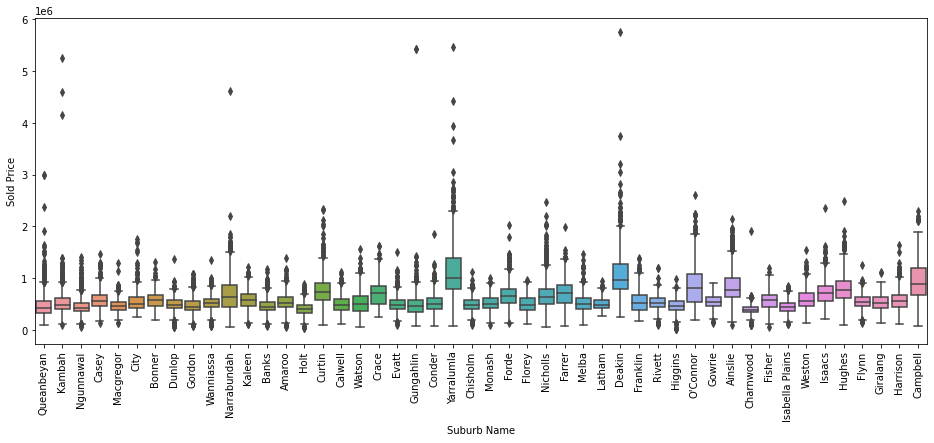

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.boxplot(x="Suburb Name", y="Sold Price",
            data=houses)

Consistent with expectations, it looks like houses sold near the city (i.e. Yarralumla, Deakin, O'Connor, Ainslie, Campbell) go for the highest prices. I'd like to be able to overlay the locations of properties for which we have sales data onto a map containing the suburb boundaries. This serves mostly an aesthetic goal, not an analytic one - if we wanted an actual goal, we could colour suburbs by their median sale price, and highlight properties that are particularly cheap or expensive in each suburb.

## Visualising Suburb Boundaries

In [13]:
import geopandas as gpd

## import data
act_suburb_data = gpd.read_file("geo_features.geojson") ## contains info for all suburbs

In [14]:
## get price data into format we can merge with geometry data
houses['Suburb Name'] = houses['Suburb Name'].str.upper()

median_prices = pd.DataFrame(houses.groupby('Suburb Name', as_index=False)["Sold Price"].median())
median_prices.columns = ['act_loca_2', 'medianprice']

median_prices.head()
actgeo_gdf=act_suburb_data.merge(median_prices,on="act_loca_2")

actgeo_gdf.head()

id lc_ply_pid   dt_create  \
0   ckan_0257a9da_b558_4d86_a987_535c775cf8d8.2      16922  2019-05-22   
1   ckan_0257a9da_b558_4d86_a987_535c775cf8d8.7      16880  2019-05-22   
2   ckan_0257a9da_b558_4d86_a987_535c775cf8d8.8      16813  2019-05-22   
3   ckan_0257a9da_b558_4d86_a987_535c775cf8d8.9      16819  2019-05-22   
4  ckan_0257a9da_b558_4d86_a987_535c775cf8d8.12      16944  2019-05-22   

  dt_retire loc_pid  act_locali act_loca_1 act_loca_2 act_loca_3 act_loca_4  \
0      None  ACT125  2018-06-26       None     WATSON       None       None   
1      None  ACT566  2018-06-26       None     LATHAM       None       None   
2      None  ACT601  2018-06-26       None     KAMBAH       None       None   
3      None  ACT602  2018-06-26       None  WANNIASSA       None       None   
4      None  ACT914  2018-11-08       None  GUNGAHLIN       None       9999   

  act_loca_5 act_loca_6 act_loca_7  \
0          G       None          8   
1          G       None          8   
2          G       None          8   
3          G       None          8   
4          D       None          8   

                                            geometry  medianprice  
0  MULTIPOLYGON (((149.16601 -35.24007, 149.16536...       500000  
1  MULTIPOLYGON (((149.02799 -35.22165, 149.02795...       487000  
2  MULTIPOLYGON (((149.07313 -35.39600, 149.07210...       490000  
3  MULTIPOLYGON (((149.10342 -35.40614, 149.10246...       515000  
4  MULTIPOLYGON (((149.16809 -35.22400, 149.16130...       470000

In [15]:
import folium

## coordinates from wiki
initial_lat = -35.473469
initial_lng = 149.012375

# Creating a map object
act_map = folium.Map(location=[initial_lat, initial_lng], zoom_start=9, tile=None)
folium.TileLayer('CartoDB positron').add_to(act_map)

# Creating choropleth map
folium.Choropleth(
    geo_data=actgeo_gdf,
    data=actgeo_gdf,
    columns=["act_loca_2", "medianprice"],
    key_on="feature.properties.act_loca_2",
    fill_color="YlGn",
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name="Median House Price (1970 - 2021; $)",
    highlight=True,
).add_to(act_map)

# Adding labels to map
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

SuburbName = folium.features.GeoJson(
    actgeo_gdf,
    style_function=style_function, 
    control=False,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['act_loca_2'
                ,'medianprice'
               ],
        aliases=['SuburbName: '
                ,'Median Price: ' 
                 ],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
act_map.add_child(SuburbName)
act_map.keep_in_front(SuburbName)
folium.LayerControl().add_to(act_map)

act_map

From the above map, it's clear that median house prices over the period 1970-2021 reflect a geographical pattern: the closer you are to the city centre, the more expensive the house sales. This is intuitive, but it's nice to see it reflected nonetheless.

### The Role of Time

The above analysis has focused on collecting information about house prices in popular Canberra suburbs, aggregated over the entire collection period. What about a year-by-year breakdown of median house prices, and the same for particular suburbs?

In [16]:
def get_house_sales_by_date(start_year, end_year):

    start_date = f"{start_year}-1-1"
    end_date = f"{end_year}-1-1"
    
    after_start_date = houses["Sold Date"] >= start_date
    before_end_date = houses["Sold Date"] <= end_date
    between_two_dates = after_start_date & before_end_date
    filtered_dates = houses.loc[between_two_dates]
    
    df_start_date_end_date = filtered_dates.groupby("Suburb Name")["Sold Price"].agg(['count'])
    df_start_date_end_date.columns = [f"{start_year}-{end_year} Sales Count"]

    return df_start_date_end_date

def get_median_sales_by_date(start_year, end_year):

    start_date = f"{start_year}-1-1"
    end_date = f"{end_year}-1-1"
    
    after_start_date = houses["Sold Date"] >= start_date
    before_end_date = houses["Sold Date"] <= end_date
    between_two_dates = after_start_date & before_end_date
    filtered_dates = houses.loc[between_two_dates]
    
    df_start_date_end_date = filtered_dates.groupby("Suburb Name")["Sold Price"].agg(['median'])
    df_start_date_end_date.columns = [f"{start_year}-{end_year} Median Price"]

    return df_start_date_end_date

suburb_yearly_sales = houses[["Suburb Name"]].drop_duplicates(ignore_index=True)
suburb_yearly_median_price = houses[["Suburb Name"]].drop_duplicates(ignore_index=True)
for i in range(1970,2021):
    temp_df = get_house_sales_by_date(str(i), str(i+1))
    suburb_yearly_sales=suburb_yearly_sales.merge(temp_df,on="Suburb Name", how='left')
    temp_df = get_median_sales_by_date(str(i), str(i+1))
    suburb_yearly_median_price=suburb_yearly_median_price.merge(temp_df,on="Suburb Name", how='left')
    

### BEGIN Dealing with bad choices    
suburb_yearly_sales = suburb_yearly_sales.transpose()
suburb_yearly_median_price = suburb_yearly_median_price.transpose()

suburb_yearly_median_price.columns = suburb_yearly_median_price.iloc[0]
suburb_yearly_sales.columns = suburb_yearly_sales.iloc[0]

suburb_yearly_median_price = suburb_yearly_median_price.drop("Suburb Name")
suburb_yearly_sales = suburb_yearly_sales.drop("Suburb Name")

## we want a non-zero filler for where data does not exist.
## seaborn would plot zeroes when using lineplot, won't accepts NaNs, 
## but will accept and not plot np.inf's
suburb_yearly_median_price = suburb_yearly_median_price.fillna(np.inf)
suburb_yearly_sales = suburb_yearly_sales.fillna(0)
### END Dealing with bad choices

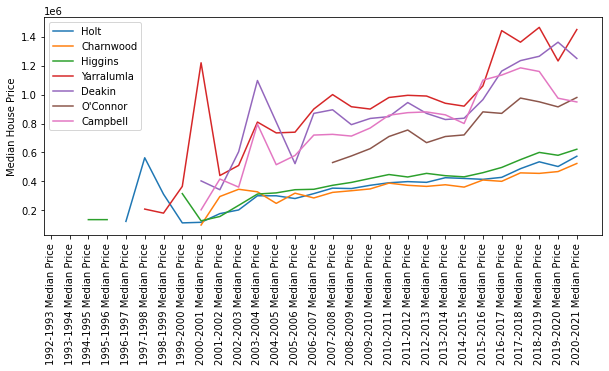

In [17]:
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)
sns.lineplot(data=suburb_yearly_median_price["HOLT"], label="Holt")
sns.lineplot(data=suburb_yearly_median_price["CHARNWOOD"], label="Charnwood")
sns.lineplot(data=suburb_yearly_median_price["HIGGINS"], label="Higgins")
sns.lineplot(data=suburb_yearly_median_price["YARRALUMLA"], label="Yarralumla")
sns.lineplot(data=suburb_yearly_median_price["DEAKIN"], label="Deakin")
sns.lineplot(data=suburb_yearly_median_price["O'CONNOR"], label="O'Connor")
sns.lineplot(data=suburb_yearly_median_price["CAMPBELL"], label="Campbell")
plt.ylabel("Median House Price")
plt.legend()

## Some Observations:
1. Median house prices are invariably trending upwards over the period 1970-2021
2. This upward trend is true of both 'cheaper' and 'dearer' neighbourhoods, like Charnwood or Yarralumla, respectively
3. The first few years of data for a particular suburb typically have a 'spike': is this due to interest in a recently-gazetted suburb? I looked on Wikipedia for pertinent events around 2000-2001 in Yarralumla, but couldn't find anything - nonetheless, it seems unusual that the median house price for a region increases from ~400k to 1.2m in a year; how many datapoints are yielding that trend? (From below graph, less than 10, making this observation an artefact of insufficient data)

<AxesSubplot:ylabel='YARRALUMLA'>

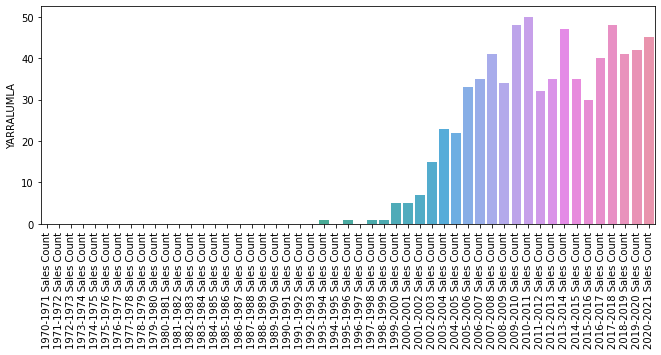

In [18]:
plt.figure(figsize=(11, 4))
plt.xticks(rotation=90)

sns.barplot(x=suburb_yearly_sales.index,
           y=suburb_yearly_sales["YARRALUMLA"])

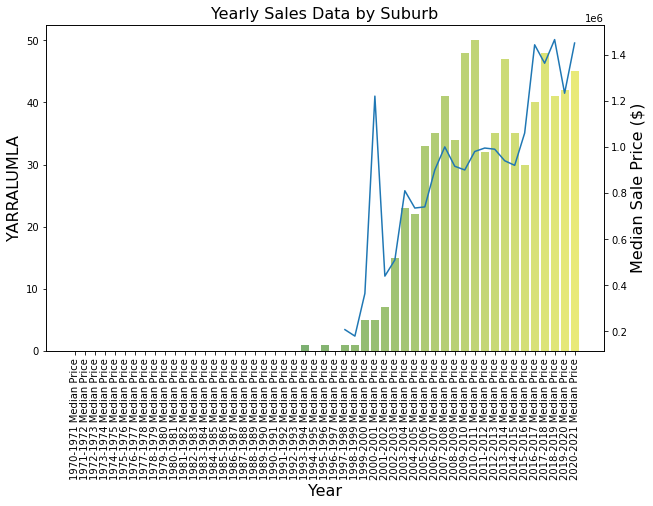

In [19]:
suburb_of_interest = "YARRALUMLA"

#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
plt.xticks(rotation=90)

#bar plot creation
ax1.set_title('Yearly Sales Data by Suburb', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Number of Sales', fontsize=16)
ax1 = sns.barplot(x=suburb_yearly_sales.index, y=suburb_yearly_sales[suburb_of_interest], palette='summer')
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()

#line plot creation
ax2.set_ylabel('Median Sale Price ($)', fontsize=16)
ax2 = sns.lineplot(data = suburb_yearly_median_price[suburb_of_interest])
ax2.tick_params(axis='y')

#show plot
plt.show()

## Conclusions So Far

We've established some basic trends about the Canberra property market:
1. House prices are trending upwards over time in most, if not all, suburbs
2. House prices are strongly correlated with location, particularly if you are close to the city centre

Therefore, and for the sake of limiting the number of FourSquare API calls that I have to make, I will build a model using only house sales from 2020-2021, and I will build suburb profiles (as opposed to property profiles), where I make a list of the most common venues for a given suburb. There are three reasons for this:
1. Limiting number of API calls (as I only have a free account)
2. Recent sale prices will influence current prices more than historical prices
3. API calls is current, and will use existing contemporary venues to build a model - historically, these venues might not have existed when a particular house was sold, meaning we have to either collect info on the age of all venues, or we build a model on the basis of house sales in the last year, and assume that house prices were influenced by currently-existing venues. (For parks / public services, this might be okay - for particular restaurants, maybe not).

## Setting up OpenCage API; Appending Suburb Latitude and Longitude to House Data

As above, I'll need a latitude and longitude for each of the Canberra suburbs, and merge this with the current houses dataframe. Then, we can pass the suburb_lat and suburb_lng to FourSquare, and start producing a suburb profile. I'm going to use the OpenCage API to get latitudes and longitudes for the suburbs, because it seemed the quickest to set up.

In [20]:
#pip install opencage
from opencage.geocoder import OpenCageGeocode

In [21]:
def get_opencage_lat_lng(suburb_name):

    key = 'b1227dd339614085b4788c3a4d9ca2e7'
    geocoder = OpenCageGeocode(key)
    query = f"{suburb_name}, CANBERRA, ACT"
    results = geocoder.geocode(query)
    
    return results[0]['geometry']['lat'], results[0]['geometry']['lng']

In [22]:
suburb_name_list = list(houses["Suburb Name"].unique())
sub_lat_lng_dict = dict.fromkeys(suburb_name_list)

for suburb_name in suburb_name_list:
    sub_lat_lng_dict[suburb_name] = list(get_opencage_lat_lng(suburb_name))

In [23]:
sub_lat_lng_df = pd.DataFrame.from_dict(sub_lat_lng_dict, orient='index', 
                                        columns=["Suburb Latitude", "Suburb Longitude"])


sub_lat_lng_df.reset_index(level=0, inplace=True)
sub_lat_lng_df.rename(columns={"index": "Suburb Name"}, inplace=True)

houses = houses.merge(sub_lat_lng_df, on="Suburb Name")

In [25]:
sub_lat_lng_df.head()

Suburb Name  Suburb Latitude  Suburb Longitude
0  QUEANBEYAN       -35.283460        149.128070
1      KAMBAH       -35.377680        149.010202
2   NGUNNAWAL       -35.172800        149.111470
3       CASEY       -35.304247        149.120092
4   MACGREGOR       -35.316064        149.106841

## Setting up Foursquare API

In [26]:
CLIENT_ID = 'NCOK3XLOBXPSZAGSGJ5ND3F0MOYUQGHQIMKHXHWFVSOUZWYV' # your Foursquare ID
CLIENT_SECRET = 'UPPMLT05HXXFDSVBYTEKTPRIBRRHFBMHB35REQM1QH2XPI5B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius= 2000 ## Increased from 250 (then 1000) based on number of results

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb Name', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
## cell executed at 5:32pm, 31st March, 2021

suburb_venues = getNearbyVenues(names=sub_lat_lng_df['Suburb Name'],
                                   latitudes=sub_lat_lng_df['Suburb Latitude'],
                                   longitudes=sub_lat_lng_df['Suburb Longitude']
                                  );

In [29]:
suburb_venues.head()

Suburb Name  Suburb Latitude  Suburb Longitude                  Venue  \
0  QUEANBEYAN        -35.28346         149.12807   Group Seven Espresso   
1  QUEANBEYAN        -35.28346         149.12807       The Cupping Room   
2  QUEANBEYAN        -35.28346         149.12807         Two Before Ten   
3  QUEANBEYAN        -35.28346         149.12807  Močan and Green Grout   
4  QUEANBEYAN        -35.28346         149.12807          Impact Comics   

   Venue Latitude  Venue Longitude Venue Category  
0      -35.281864       149.124639    Coffee Shop  
1      -35.280472       149.126106    Coffee Shop  
2      -35.279753       149.126229           Café  
3      -35.284578       149.125029           Café  
4      -35.278405       149.132024     Comic Shop

## Notes about FourSquare Output

I notice that the output of the FourSquare API includes venues such as intersections. Personally, I wouldn't use an intersection to guide my valuation of a house - BUT, I will concede that for some, being too close to an intersection might be detrimental to the price (or vice-versa if you wanted to live near a collector road, for example). For this reason, I will leave in the intersections.

In [474]:
#suburb_venues.groupby('Suburb Name').size()

In [30]:
print('There are {} unique categories.'.format(len(suburb_venues['Venue Category'].unique())))

There are 161 unique categories.


## One-Hot Encoding of Suburb Venues

In [31]:
# one hot encoding
act_onehot = pd.get_dummies(suburb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
act_onehot['Suburb Name'] = suburb_venues['Suburb Name'] 

# move neighborhood column to the first column
fixed_columns = [act_onehot.columns[-1]] + list(act_onehot.columns[:-1])
act_onehot = act_onehot[fixed_columns]

In [32]:
act_grouped = act_onehot.groupby('Suburb Name').mean().reset_index()
act_grouped.head()

Suburb Name  Art Gallery  Asian Restaurant  Athletics & Sports  \
0     AINSLIE         0.00          0.056338                 0.0   
1      AMAROO         0.02          0.010000                 0.0   
2       BANKS         0.00          0.020000                 0.0   
3      BONNER         0.00          0.000000                 0.0   
4     CALWELL         0.00          0.000000                 0.1   

   Australian Restaurant    Bakery  Bank       Bar  Baseball Stadium  \
0               0.028169  0.028169   0.0  0.014085               0.0   
1               0.030000  0.010000   0.0  0.020000               0.0   
2               0.010000  0.010000   0.0  0.030000               0.0   
3               0.000000  0.000000   0.0  0.000000               0.0   
4               0.000000  0.000000   0.0  0.000000               0.0   

   Basketball Stadium  ...  Train Station  Turkish Restaurant  \
0                 0.0  ...            0.0                 0.0   
1                 0.0  ...            0.0                 0.0   
2                 0.0  ...            0.0                 0.0   
3                 0.0  ...            0.0                 0.0   
4                 0.0  ...            0.0                 0.0   

   Vegetarian / Vegan Restaurant  Veterinarian  Vietnamese Restaurant  \
0                       0.028169           0.0               0.028169   
1                       0.000000           0.0               0.010000   
2                       0.000000           0.0               0.020000   
3                       0.000000           0.0               0.000000   
4                       0.000000           0.1               0.000000   

   Volleyball Court  Whisky Bar  Wine Bar  Yoga Studio  Zoo  
0               0.0        0.00      0.00          0.0  0.0  
1               0.0        0.01      0.02          0.0  0.0  
2               0.0        0.01      0.02          0.0  0.0  
3               0.0        0.00      0.00          0.0  0.0  
4               0.0        0.00      0.00          0.0  0.0  

[5 rows x 162 columns]

We make the shaky assumptions that people buying a house in a particular suburb only care about the venues in that suburb - not even those venues next to their house but over suburb lines would matter. We also make the assumption in the collection of this data that a circle around the geographical centre of the suburb is representative of that suburbs venues (this assumption is required because the alternative cannot be done with the number of API calls I'm permitted to make).

In [33]:
houses = houses.merge(act_grouped, on="Suburb Name")

In [34]:
## To remove potentially complicated role of year of sale, we 
## only consider the last 5 years of sale data in our model

after_start_date = houses["Sold Date"] >= "2016-1-1"
before_end_date = houses["Sold Date"] <= "2021-1-31"
between_two_dates = after_start_date & before_end_date
houses_modelling = houses.loc[between_two_dates]

In [35]:
houses_modelling = houses_modelling.drop(columns=["Postcode", "Suburb Link", "Street Address", "Sold Date", "Property Link",
                      "Suburb Latitude", "Suburb Longitude"])

## suburb name should not be used in the model - we keep it only for the sake of understanding
## property type should be encoded

In [36]:
houses_modelling.head()

Suburb Name  Recent Sales   Latitude   Longitude Property Type  Beds  \
34  QUEANBEYAN           226 -35.356247  149.223241         house     4   
35  QUEANBEYAN           226 -35.353797  149.244797     townhouse     2   
36  QUEANBEYAN           226 -35.345395  149.226876          unit     2   
37  QUEANBEYAN           226 -35.366636  149.229487         house     3   
38  QUEANBEYAN           226 -35.352005  149.240680          unit     2   

    Baths  Cars  Sold Price  Art Gallery  ...  Train Station  \
34      4     4      770000         0.01  ...            0.0   
35      1     2      425000         0.01  ...            0.0   
36      2     1      325000         0.01  ...            0.0   
37      1     1      500000         0.01  ...            0.0   
38      1     1      263000         0.01  ...            0.0   

    Turkish Restaurant  Vegetarian / Vegan Restaurant  Veterinarian  \
34                 0.0                            0.0           0.0   
35                 0.0                            0.0           0.0   
36                 0.0                            0.0           0.0   
37                 0.0                            0.0           0.0   
38                 0.0                            0.0           0.0   

    Vietnamese Restaurant  Volleyball Court  Whisky Bar  Wine Bar  \
34                   0.01               0.0        0.01      0.02   
35                   0.01               0.0        0.01      0.02   
36                   0.01               0.0        0.01      0.02   
37                   0.01               0.0        0.01      0.02   
38                   0.01               0.0        0.01      0.02   

    Yoga Studio  Zoo  
34          0.0  0.0  
35          0.0  0.0  
36          0.0  0.0  
37          0.0  0.0  
38          0.0  0.0  

[5 rows x 170 columns]

In [37]:
# one hot encoding
houses_modelling_onehot = pd.get_dummies(houses_modelling[['Property Type']], prefix="", prefix_sep="")

In [38]:
houses_modelling = houses_modelling.join(houses_modelling_onehot)
houses_modelling = houses_modelling.drop(columns=["Property Type"])

In [39]:
cols = list(houses_modelling.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Sold Price')) #Remove Sold Price from list
houses_modelling = houses_modelling[cols+['Sold Price']] #Create new dataframe with columns in the order you want

In [40]:
houses_modelling.head()

Suburb Name  Recent Sales   Latitude   Longitude  Beds  Baths  Cars  \
34  QUEANBEYAN           226 -35.356247  149.223241     4      4     4   
35  QUEANBEYAN           226 -35.353797  149.244797     2      1     2   
36  QUEANBEYAN           226 -35.345395  149.226876     2      2     1   
37  QUEANBEYAN           226 -35.366636  149.229487     3      1     1   
38  QUEANBEYAN           226 -35.352005  149.240680     2      1     1   

    Art Gallery  Asian Restaurant  Athletics & Sports  ...  house  lifestyle  \
34         0.01              0.01                 0.0  ...      1          0   
35         0.01              0.01                 0.0  ...      0          0   
36         0.01              0.01                 0.0  ...      0          0   
37         0.01              0.01                 0.0  ...      1          0   
38         0.01              0.01                 0.0  ...      0          0   

    retirement living  studio  terrace  townhouse  unit  unitblock  villa  \
34                  0       0        0          0     0          0      0   
35                  0       0        0          1     0          0      0   
36                  0       0        0          0     1          0      0   
37                  0       0        0          0     0          0      0   
38                  0       0        0          0     1          0      0   

    Sold Price  
34      770000  
35      425000  
36      325000  
37      500000  
38      263000  

[5 rows x 181 columns]

## Predicting House Prices with Multiple Linear Regression

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [1346]:
Y = houses_modelling["Sold Price"]
X = houses_modelling.drop(columns=["Suburb Name", "Sold Price"])
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train,Y_train)

regressor.score(X_test,Y_test)

0.7331893829226663

We get an R^2 value of 0.733. This is fine, I guess. Better than flipping a coin, and one has to wonder if setting house prices would take into account all of these factors, or whether its more of an art, than a science.

However, we haven't performed regularization of the variables, and with > 150 variables, it's very likely that our high R^2 value is an artefact of overfitting. We can use Backward Elimination to determine which variables, if any, have the largest effect upon the prediction, and if we have significant multicollinearity issues.

We will proceed with a p-value of 1E-12, a very-stringent value because we have many, probably unneccesary, variables

## Backward Elimination; Model Incl. Suburb Venue Profile

In [73]:
def do_backward_elimination(columns, alpha=0.001):
    
    ## set up the predictor and predicted arrays
    ## we remove one of the house types, because by construction, the sum of all the house
    ## types = 1, and that leads to collinearity
    Y = houses_modelling["Sold Price"]
    X = houses_modelling.drop(columns=["Suburb Name", "Sold Price", "villa"])
    
    ## 80/20 train/test split
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

    ## Do some regularization - lots of variables
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ## scaler returns np.ndarrays, we want pd.dataframes
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    
    ## add a constant to the model, so we can center our R^2
    X_train = sm.add_constant(X_train)

    Y_train = pd.DataFrame(Y_train)
    Y_train = Y_train.reset_index(drop=True)

    Y_test = pd.DataFrame(Y_test)
    Y_test = Y_test.reset_index(drop=True)
    
    if len(columns)!=0:
        X_train = X_train.drop(columns=columns)
        
    ## train the model on the training set
    unique_model = sm.OLS(Y_train,X_train).fit()
    
    if max(unique_model.pvalues) > alpha:
        columns.append(unique_model.pvalues.idxmax())
        unique_model = do_backward_elimination(columns=columns, alpha=alpha)
    
    X_test = X_test.drop(columns=columns)
    X_test = sm.add_constant(X_test)
    unique_model_test = sm.OLS(Y_test,X_test).fit()
    
    return unique_model_test

In [74]:
columns = []
x = do_backward_elimination(columns, alpha=1E-12)
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sold Price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     234.5
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:25:02   Log-Likelihood:                -39004.
No. Observations:                2916   AIC:                         7.808e+04
Df Residuals:                    2882   BIC:                         7.828e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.58e+05   2931.375    224.466      0.000    6.52e+05    6.64e+05
0          -4.444e+04   3934.545    -11.295      0.000   -5.22e+04   -3.67e+04
2          -2.691e+04   4799.871     -5.607      0.000   -3.63e+04   -1.75e+04
3           9.578e+04   4946.865     19.363      0.000    8.61e+04    1.05e+05
4           5.758e+04   3873.707     14.864      0.000       5e+04    6.52e+04
5           1.844e+04   3155.684      5.844      0.000    1.23e+04    2.46e+04
14              2e+04   1481.219     13.500      0.000    1.71e+04    2.29e+04
16         -1.565e+04   1634.986     -9.573      0.000   -1.89e+04   -1.24e+04
20          1.195e+05   5989.572     19.954      0.000    1.08e+05    1.31e+05
21         -1.565e+04   1634.986     -9.573      0.000   -1.89e+04   -1.24e+04
25          -1.95e+04   3093.529     -6.302      0.000   -2.56e+04   -1.34e+04
29         -1.669e+04   3773.220     -4.424      0.000   -2.41e+04   -9293.115
30         -1.565e+04   1634.986     -9.573      0.000   -1.89e+04   -1.24e+04
33         -1.565e+04   1634.986     -9.573      0.000   -1.89e+04   -1.24e+04
34          4.133e+04   5887.643      7.020      0.000    2.98e+04    5.29e+04
45         -1.229e+04   1696.796     -7.242      0.000   -1.56e+04   -8961.441
47          5.591e+04   5322.131     10.505      0.000    4.55e+04    6.63e+04
48          9563.2562   1485.341      6.438      0.000    6650.818    1.25e+04
54         -6.843e+04   1.23e+04     -5.548      0.000   -9.26e+04   -4.42e+04
57         -1.487e+05   6440.949    -23.084      0.000   -1.61e+05   -1.36e+05
60              2e+04   1481.219     13.500      0.000    1.71e+04    2.29e+04
63         -1.565e+04   1634.986     -9.573      0.000   -1.89e+04   -1.24e+04
68         -1.328e+05   4792.662    -27.719      0.000   -1.42e+05   -1.23e+05
73         -3.549e+04   3755.768     -9.451      0.000   -4.29e+04   -2.81e+04
74           2.07e+05   5854.659     35.360      0.000    1.96e+05    2.19e+05
77          1.354e+04   1520.826      8.903      0.000    1.06e+04    1.65e+04
83         -1.207e+05   1.02e+04    -11.857      0.000   -1.41e+05   -1.01e+05
94          4.133e+04   5887.643      7.020      0.000    2.98e+04    5.29e+04
97          1.195e+05   5989.572     19.954      0.000    1.08e+05    1.31e+05
99         -1.288e+05   1.57e+04     -8.214      0.000    -1.6e+05    -9.8e+04
101        -2.758e+04   2479.765    -11.120      0.000   -3.24e+04   -2.27e+04
109        -8.988e+04   9512.156     -9.449      0.000   -1.09e+05   -7.12e+04
114         1.113e+05   6546.007     17.007      0.000    9.85e+04    1.24e+05
117             2e+04   1481.219     13.500      0.000    1.71e+04    2.29e+04
119             2e+04   1481.219     13.500      0.000    1.71e+04    2.29e+04
126         -4.62e+04   2615.213    -17.666      0.000   -5.13e+04   -4.11e+04
12

## Backward Elimination; Model Without Suburb Venue Profile

In [75]:
## note that we exclude one property type from this list - because the sum of all 
## the property types would equal 1, and thus be collinear
keep_list = ["Recent Sales", "Latitude", "Longitude", "Beds", "Baths", "Cars", "apartment", 
             "duplex-semi-detached", "house", "lifestyle", "retirement living", "studio", 
             "terrace", "townhouse", "unit", "unitblock", "villa", "Sold Price"]

houses_modelling_keep = houses_modelling[keep_list]
houses_modelling_keep.head()

Recent Sales   Latitude   Longitude  Beds  Baths  Cars  apartment  \
34           226 -35.356247  149.223241     4      4     4          0   
35           226 -35.353797  149.244797     2      1     2          0   
36           226 -35.345395  149.226876     2      2     1          0   
37           226 -35.366636  149.229487     3      1     1          0   
38           226 -35.352005  149.240680     2      1     1          0   

    duplex-semi-detached  house  lifestyle  retirement living  studio  \
34                     0      1          0                  0       0   
35                     0      0          0                  0       0   
36                     0      0          0                  0       0   
37                     0      1          0                  0       0   
38                     0      0          0                  0       0   

    terrace  townhouse  unit  unitblock  villa  Sold Price  
34        0          0     0          0      0      770000  
35        0          1     0          0      0      425000  
36        0          0     1          0      0      325000  
37        0          0     0          0      0      500000  
38        0          0     1          0      0      263000

In [80]:
def do_backward_elimination_manual(man_columns, alpha=0.001):
    
    ## set up the predictor and predicted arrays
    Y_manual = houses_modelling_keep["Sold Price"]
    X_manual = houses_modelling_keep.drop(columns=["Sold Price"])
    
    ## 80/20 train/test split
    X_train_man, X_test_man, Y_train_man, Y_test_man = train_test_split( X_manual, Y_manual, test_size=0.2)

    ## Do some regularization - lots of variables
    scaler = StandardScaler()
    X_train_man = scaler.fit_transform(X_train_man)
    X_test_man = scaler.transform(X_test_man)

    ## scaler returns np.ndarrays, we want pd.dataframes
    X_train_man = pd.DataFrame(X_train_man)
    X_test_man = pd.DataFrame(X_test_man)
    
    ## add a constant to the model, so we can center our R^2
    X_train_man = sm.add_constant(X_train_man)
    X_test_man = sm.add_constant(X_test_man)
    
    Y_train_man = pd.DataFrame(Y_train_man)
    Y_train_man = Y_train_man.reset_index(drop=True)

    Y_test_man = pd.DataFrame(Y_test_man)
    Y_test_man = Y_test_man.reset_index(drop=True)
    
    if len(columns)!=0:
        X_train_man = X_train_man.drop(columns=man_columns)
        
    ## train the model on the training set
    manual_model = sm.OLS(Y_train_man,X_train_man).fit()
    
    if max(manual_model.pvalues) > alpha:
        man_columns.append(manual_model.pvalues.idxmax())
        manual_model = do_backward_elimination_manual(man_columns=man_columns, alpha=alpha)
    
    X_test_man = X_test_man.drop(columns=man_columns)
    X_test_man = sm.add_constant(X_test_man)
    manual_model_test = sm.OLS(Y_test_man,X_test_man).fit()
    
    return manual_model_test

In [81]:
man_columns = []
man_model = do_backward_elimination_manual(man_columns, alpha=1E-12)
man_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sold Price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     466.8
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:28:02   Log-Likelihood:                -39981.
No. Observations:                2916   AIC:                         7.997e+04
Df Residuals:                    2910   BIC:                         8.001e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.494e+05   4042.960    160.635      0.000    6.42e+05    6.57e+05
0          -5.985e+04   4335.781    -13.803      0.000   -6.84e+04   -5.13e+04
2           4.041e+04   4459.544      9.060      0.000    3.17e+04    4.91e+04
3            8.76e+04   6316.956     13.868      0.000    7.52e+04       1e+05
4           8.305e+04   5278.979     15.733      0.000    7.27e+04    9.34e+04
8           5.584e+04   5158.214     10.825      0.000    4.57e+04     6.6e+04
==============================================================================
Omnibus:                     2069.871   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48304.140
Skew:                           3.086   Prob(JB):                         0.00
Kurtosis:                      21.960   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Conclusions

## What was the goal?

To develop a model which could predict fair house prices in the Canberra region, by using location data, past sales data, and venue data.

## Did we achieve the goal?

We developed a model which can predict house prices in the Canberra region with an R^2 = 0.45 after centering, regularization, and backward elimination, and requires only information about the number of recent sales in the area, the longitude of the house, the numbers of beds and baths, and whether it's a house or not (i.e. a townhouse or unit).

This is a low score, but it's interesting to note that:
1. Only the longitude (not latitude) has a strong effect on house price. This is kind of funny because, as we can see from the map above, the A.C.T. is a long state, but not a wide one - and this is reflected one-dimensionally in the house prices and latitude. It could be fun to plot house prices versus latitude, (another time).
2. The number of car spaces does not have a strong role in determining house prices in this model, and less of a role than knowing some information about the 'demand' of the area, as reflected through the numbers of recent sales.
3. The strongest determining factor of house prices by property type, is whether the property is-a-house or is-not-a-house. Other property types have no strong effect upon price - which reflects perhaps that houses are expensive, and all other residential property types are similarly-priced when considering all the other variables.


We also used venue data from FourSquare (per assignment requirements) to determine if we could improve our model predictions by incorporating information about the venues available to each suburb (but not across suburb boundaries). We were limited in our ability to build property-specific profiles by the number of API calls I was allowed to make. Including suburb venue data increased our R^2 value to 0.73 after centering, regularization, and backward elimination. 

However, without doing too much model validation, it is very likely that this model has issues with collinearity which I couldn't remove, despite some effort. It is possible that venue data is by construction collinear, because venues will cluster together in shopping centres. From the perspective of the model, then, one could for example say that the existence of a supermarket venue implies the existence of a takeaway venue, because they are so often found together in the radius of our search. The end result is probably that the resulting model is over-fit - this might be able to be remedied with some validation beyond the backward elimination - but this will do for now.